## Introduction to UNET

UNET is an encoder-decoder network which improves upon architecture the fully convolutional network (FCN) in order to produce image segmentation.

1. The encoder (contracting path) reduces spatial info but increases feature depth, capturing context (i.e. what the image contains)

2. The decoder (expanding path) upsamples and combines with encoder's features to localize the objects precisely (i.e. where the image contains an object)

3. The skip connections in-between allow the encoder's features to be concatenated to the decoder's features, essentially combining context with localization in order to reconstruct the image with better understanding.

## Implementation

### Data Loading

We will load the necessary libraries and define the paths to the training and test images and labels. We will also define a transform to convert the images to tensors.

In [1]:
# Load the necessary libraries
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

#### Training Data

In [2]:
# Load training images
train_img_path = "Dataset/train/imgs"
train_label_path = "Dataset/train/labels"

# Define a transform to convert images to tensors
transform = transforms.ToTensor()

# Load and transform images
train_images = [transform(Image.open(os.path.join(train_img_path, img))) for img in os.listdir(train_img_path)]
train_labels = [transform(Image.open(os.path.join(train_label_path, label))) for label in os.listdir(train_label_path)]

# Convert lists to tensors
train_images = torch.stack(train_images)
train_labels = torch.stack(train_labels)

#### Test Data

In [3]:
# Load test images
test_img_path = "Dataset/test/imgs"
test_label_path = "Dataset/test/labels"

# Load and transform images
test_images = [transform(Image.open(os.path.join(test_img_path, img))) for img in os.listdir(test_img_path)]
test_labels = [transform(Image.open(os.path.join(test_label_path, label))) for label in os.listdir(test_label_path)]

# Convert lists to tensors
test_images = torch.stack(test_images)
test_labels = torch.stack(test_labels)

### Data Augmentation

According to the original paper, we apply the following augmentation techniques

* **Geometric transformations** (Shifts i.e. Translations and Rotations)
* **Random elastic deformations**, where a coarse grid of displacement vectors is sampled from a Gaussian and then interpolated (often referred to as “elastic deformation” in image augmentation).
* **Gray-value (intensity) variations**, aiming to make the network robust to changes in brightness/contrast
* **Dropout: implicit augmentation**

#### Geometric Transformation: Translation

In [4]:
from torchvision.transforms import functional as F

# Define a function to apply translation
def translate_image(image, x_translation, y_translation):
    return F.affine(image, angle=0, translate=(x_translation, y_translation), scale=1.0, shear=0)

# Apply translation to all training images and labels with different translations
min_translation = 5
max_translation = 20

translated_train_images = []
translated_train_labels = []

for img, label in zip(train_images, train_labels):
    x_translation = np.random.uniform(min_translation, max_translation)
    y_translation = np.random.uniform(min_translation, max_translation)
    translated_train_images.append(translate_image(img, x_translation, y_translation))
    translated_train_labels.append(translate_image(label, x_translation, y_translation))

# Covert lists to tensors
translated_train_images = torch.stack(translated_train_images)
translated_train_labels = torch.stack(translated_train_labels)

In [5]:
import matplotlib.pyplot as plt

# Define a common function to visualize images and labels
def visualize_images_and_labels(images, labels, num_images=5):
    # Horizontally stack the first 5 translated images and their corresponding translated labels
    fig, axes = plt.subplots(2, 1, figsize=(25, 10))

    # Stack translated images
    stacked_images = torch.cat([images[i] for i in range(num_images)], dim=2)
    axes[0].imshow(stacked_images.permute(1, 2, 0).numpy(), cmap='gray')
    axes[0].set_title('Stacked Translated Images')
    axes[0].axis('off')

    # Stack translated labels
    stacked_labels = torch.cat([labels[i] for i in range(num_images)], dim=2)
    axes[1].imshow(stacked_labels.permute(1, 2, 0).numpy(), cmap='gray')
    axes[1].set_title('Stacked Translated Labels')
    axes[1].axis('off')
    plt.show()


In [6]:
visualize_images_and_labels(translated_train_images, translated_train_labels)

#### Geometric Transformation: Rotation

In [7]:
# Define a function to apply rotation
def rotate_image(image, angle):
    return F.rotate(image, angle)

# Apply rotation to all training images and labels with different angles
min_angle = -30
max_angle = 30

# Generate random angles for each image
angles = np.random.uniform(min_angle, max_angle, len(train_images))

rotated_train_images = [rotate_image(img, angle) for img, angle in zip(train_images, angles)]
rotated_train_labels = [rotate_image(label, angle) for label, angle in zip(train_labels, angles)]

# Covert lists to tensors
rotated_train_images = torch.stack(rotated_train_images)
rotated_train_labels = torch.stack(rotated_train_labels)


In [8]:
visualize_images_and_labels(rotated_train_images, rotated_train_labels)


#### Random Elastic Deformation

In [9]:
import cv2
from scipy.ndimage import map_coordinates, gaussian_filter

# implementation adapted from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

# Define a function to generate affine transformation matrix
def get_affine_transform_matrix(shape_size, random_state, alpha_affine):
    
    # Calculate the center of the image
    center_square = np.float32(shape_size) // 2
    # Define the size of the square to be transformed, divide in 3 x 3 grid
    square_size = min(shape_size) // 3
    # Define the points for the affine transformation
    pts1 = np.float32([center_square + square_size, 
                       [center_square[0] + square_size, center_square[1] - square_size], 
                       center_square - square_size])
    # Apply random displacement to the points
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    # Get the affine transformation matrix
    matrix = cv2.getAffineTransform(pts1, pts2)
    # Return the affine transformation matrix
    return matrix

# Define a function to apply elastic transformation given affine transformation matrix
def elastic_transform_2d(image, gaussian_filter_x, gaussian_filter_y, affine_transform_matrix):
    # Get the shape of the image
    shape = image.shape
    # Apply the affine transformation matrix for global transformation
    image = cv2.warpAffine(image, affine_transform_matrix, shape[::-1], borderMode=cv2.BORDER_REFLECT_101)
    # Get the x and y coordinates of the image
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    # Get the indices of the image
    indices = np.reshape(y+gaussian_filter_y, (-1, 1)), np.reshape(x+gaussian_filter_x, (-1, 1))
    # Apply the elastic transformation for local transformation
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Define a function to apply elastic transformation
def apply_elastic_transform(image, label):
    """
    image, label: torch tensors (shape: (1, H, W))
    """

    # Squeeze out channel dimension if there's exactly one
    image_np = image.squeeze(0).numpy()   # shape (H, W)
    label_np = label.squeeze(0).numpy()   # shape (H, W)

    shape = image_np.shape
    shape_size = shape[:2]
    
    # Create one RandomState for reproducibility
    random_state = np.random.RandomState()

    # Randomize Alpha, Sigma and Alpha_affine
    alpha = random_state.uniform(1, shape[1] * 2)
    sigma = random_state.uniform(0.05, 0.1) * shape[1]
    alpha_affine = random_state.uniform(0.05, 0.1) * shape[1]

    # Get affine transformation matrix
    M = get_affine_transform_matrix(shape_size, random_state, alpha_affine)

    # Warp image and label
    image_np = cv2.warpAffine(image_np, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    label_np = cv2.warpAffine(label_np, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    # Generate Gaussian filter in x and y directions
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    # Apply the same dx, dy to image and label
    elastic_img_np = elastic_transform_2d(image_np, dx, dy, M)
    elastic_lbl_np = elastic_transform_2d(label_np, dx, dy, M)

    # Add channel dimension back: (1, H, W)

    elastic_img = torch.from_numpy(elastic_img_np).unsqueeze(0)
    elastic_lbl = torch.from_numpy(elastic_lbl_np).unsqueeze(0)

    return elastic_img, elastic_lbl


# Declare empty lists to store elastic transformed images and labels
elastic_train_images = []
elastic_train_labels = []

# Apply elastic transformation to all training images and labels
for img, label in zip(train_images, train_labels):
    elastic_img, elastic_label = apply_elastic_transform(img, label)
    elastic_train_images.append(elastic_img)
    elastic_train_labels.append(elastic_label)

# Covert lists to tensors
elastic_train_images = torch.stack(elastic_train_images)
elastic_train_labels = torch.stack(elastic_train_labels)

In [10]:
# Horizontally stack the first 5 original images, elastic transformed images, and their corresponding elastic transformed labels
fig, axes = plt.subplots(3, 1, figsize=(25, 15))

# Stack original images
stacked_original_images = torch.cat([train_images[i] for i in range(5)], dim=2)
axes[0].imshow(stacked_original_images.permute(1, 2, 0).numpy(), cmap='gray')
axes[0].set_title('Stacked Original Images')
axes[0].axis('off')

# Stack elastic transformed images
stacked_images = torch.cat([elastic_train_images[i] for i in range(5)], dim=2)
axes[1].imshow(stacked_images.permute(1, 2, 0).numpy(), cmap='gray')
axes[1].set_title('Stacked Elastic Transformed Images')
axes[1].axis('off')

# Stack elastic transformed labels
stacked_labels = torch.cat([elastic_train_labels[i] for i in range(5)], dim=2)
axes[2].imshow(stacked_labels.permute(1, 2, 0).numpy(), cmap='gray')
axes[2].set_title('Stacked Elastic Transformed Labels')
axes[2].axis('off')

plt.show()

#### Gray-value Variation: Brightness

In [11]:
# Define a function to apply random brightness adjustment
def adjust_brightness(image, brightness_factor):
    return F.adjust_brightness(image, brightness_factor)

# Apply random brightness adjustment to all training images and labels
min_brightness = 0.5
max_brightness = 1.5

# Generate random brightness factors for each image
brightness_factors = np.random.uniform(min_brightness, max_brightness, len(train_images))

brightened_train_images = [adjust_brightness(img, factor) for img, factor in zip(train_images, brightness_factors)]
brightened_train_labels = train_labels  # Labels remain unchanged

# Covert lists to tensors
brightened_train_images = torch.stack(brightened_train_images)

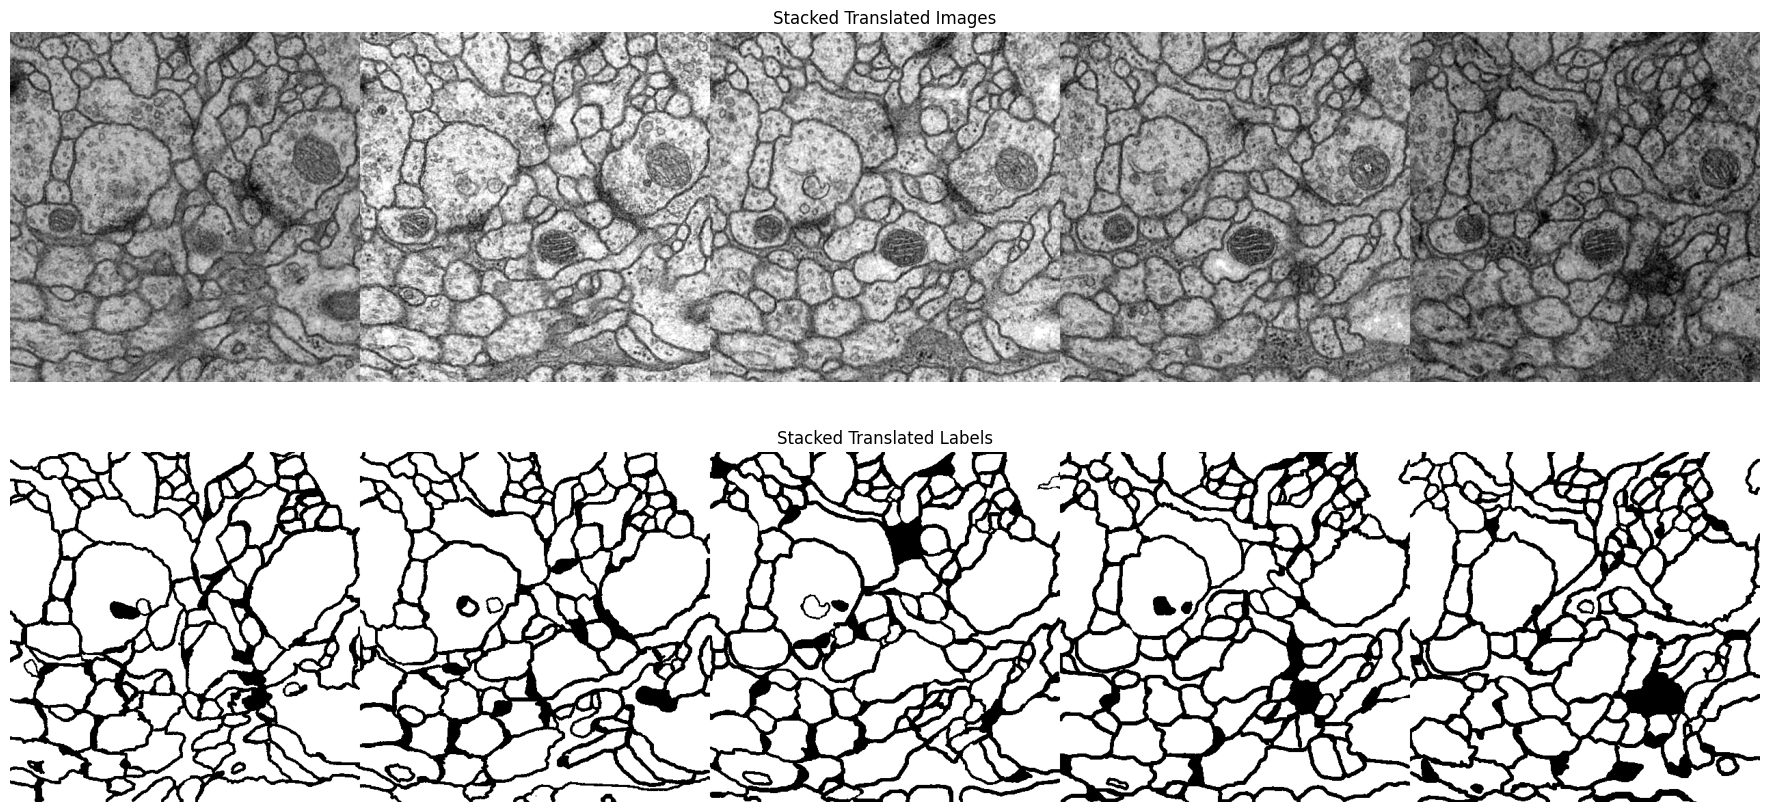

In [12]:
visualize_images_and_labels(brightened_train_images, brightened_train_labels)

#### Gray-value Variation: Contrast

In [13]:
# Define a function to apply random contrast adjustment
def adjust_contrast(image, contrast_factor):
    return F.adjust_contrast(image, contrast_factor)

# Apply random contrast adjustment to all training images and labels
min_contrast = 0.5
max_contrast = 1.5

# Generate random contrast factors for each image
contrast_factors = np.random.uniform(min_contrast, max_contrast, len(train_images))

contrasted_train_images = [adjust_contrast(img, factor) for img, factor in zip(train_images, contrast_factors)]
contrasted_train_labels = train_labels  # Labels remain unchanged

# Covert lists to tensors
contrasted_train_images = torch.stack(contrasted_train_images)

In [14]:
visualize_images_and_labels(contrasted_train_images, contrasted_train_labels)

### Dataset Creation

In this section, we will combine all the transformed images and labels into a single PyTorch dataset. This dataset will be used for training and validation of the UNET model. We will also split the dataset into training and validation sets to ensure the model's performance is evaluated on unseen data during the training data to see how it improves over time.

In [15]:
# Combine all transformation outputs into a single PyTorch dataset

from torch.utils.data import Dataset

class UNETImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Combine all transformed images and labels tensors list
new_training_images = torch.cat([train_images, translated_train_images, rotated_train_images, elastic_train_images, brightened_train_images, contrasted_train_images])
new_training_labels = torch.cat([train_labels, translated_train_labels, rotated_train_labels, elastic_train_labels, train_labels, train_labels])

# Create the dataset
train_dataset = UNETImageDataset(new_training_images, new_training_labels)
test_dataset = UNETImageDataset(test_images, test_labels)

In [16]:
# Split train_dataset into training and validation datasets
from torch.utils.data import random_split

# Define the split ratio
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for training and validation
num_train_samples = int(train_ratio * len(train_dataset))
num_val_samples = len(train_dataset) - num_train_samples

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [num_train_samples, num_val_samples])

In [18]:
# List the number of images in the training and test datasets
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")

Number of images in the training dataset: 144
Number of images in the test dataset: 30


In [19]:
# Load the datasets into dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

### Model Creation

## Model Creation

In this section, we define the UNet model architecture.  The model is implemented using PyTorch, and the architecture is printed using the `torchsummary` library.

In [20]:
# Device configuration
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [21]:
# get torch version (making sure it's the cuda enabled version)
torch_version = torch.__version__
print(f"Using torch version {torch_version}")

Using torch version 2.6.0+cu126


In [22]:
# Check image and label shapes
for images, labels in train_dataloader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    break

Image batch shape: torch.Size([10, 1, 512, 512])
Label batch shape: torch.Size([10, 1, 512, 512])


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the UNet model

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32, dropout_prob=0.5):

        # Initialize the parent class
        super(UNet, self).__init__()

        # Define the encoder part of the UNet

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Add dropout layer at the end of the contracting path.
        self.dropout = nn.Dropout2d(p=dropout_prob)

        # Define the bottleneck part of the UNet
        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        # Define the decoder part of the UNet
        
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        
        # Define the output layer

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):

        # Define the forward pass through the UNet
        # Contracting path (Encoder)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Apply dropout at the end of the contracting path
        enc4 = self.dropout(enc4)
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Expansive path (Decoder)
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1) # Concatenate the encoder output with the decoder output for each decoder block
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Return the raw logits through output layer (no sigmoid here)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

### Model Training

In [153]:
import torch.optim as optim
from tqdm import tqdm

def iou_score_image(pred, target):
    # Flatten the tensors
    pred = pred.view(-1)
    target = target.view(-1)
    # Intersection is the number of overlapping pixels
    intersection = (pred * target).sum()
    # Union is the total number of pixels in both masks
    union = pred.sum() + target.sum() - intersection
    # Avoid division by zero
    epsilon = 1e-6
    # Calculate the Intersection over Union
    iou = (intersection + epsilon) / (union + epsilon)
    return iou

def iou_score_batch(pred, target):
    batch_size = pred.size(0)
    iou = 0
    for i in range(batch_size):
        iou += iou_score_image(pred[i], target[i])
    return iou / batch_size

# Lists to store the losses and IoU scores of training and validation
train_loss = []
train_iou = []
valid_loss = []
valid_iou = []

def train_loop(dataloader, model, loss_fn, optimizer, scaler, device):
    # Lists to store the training losses and IoU scores of current epoch
    total_loss = 0.0
    total_iou = 0.0

    size = len(dataloader.dataset)

    num_batches = 0

    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(tqdm(dataloader, desc="Training")):
    
        # Send data to device
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # Keep track of losses
        loss = loss.item()
        total_loss += loss
        # Compute the Intersection over Union
        iou = iou_score_batch(torch.sigmoid(pred) > 0.5, y)
        total_iou += iou.item()
        # batch_size = X.shape[0]
        # current_batch_number = batch * batch_size + len(X)
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches

    train_loss.append(avg_loss)
    train_iou.append(avg_iou)

    print(f"Avg training loss: {avg_loss:.4f}, Avg training IoU: {avg_iou:.4f}")

def validation_loop(dataloader, model, loss_fn, device):
    # Lists to store the validation losses and IoU scores of current epoch
    total_loss = 0.0
    total_iou = 0.0

    num_batches = 0
     # Set model to evaluation mode
    model.eval() 

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Validation"):
            X, y = X.to(device), y.to(device)

            # 1) Forward pass => raw logits (no final sigmoid in the model)
            logits = model(X)  # shape: [N, 1, H, W]
            
            # 2) Compute loss
            loss = loss_fn(logits, y)  # BCEWithLogitsLoss
            total_loss += loss.item()

            # 3) Threshold logits for IoU
            pred_mask = torch.sigmoid(logits) > 0.5  # shape: [N, 1, H, W]
            
            # 4) Compute IoU (batch-level or image-level). 
            #    Example: using a batch-wise IoU function:
            batch_iou = iou_score_batch(pred_mask.float(), y.float())
            total_iou += batch_iou.item()

            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches

    valid_loss.append(avg_loss)
    valid_iou.append(avg_iou)

    print(f"Avg validation loss: {avg_loss:.4f}  Avg validation IoU: {avg_iou:.4f}")

def train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-4, device="cuda"):

    model.to(device)
    # Define the Binary Cross Entropy loss function with logits
    loss = nn.BCEWithLogitsLoss()
    # Define the Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Define the gradient scaler
    scaler = torch.amp.GradScaler()

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss, optimizer, scaler, device)
        validation_loop(val_loader, model, loss, device)
    print("Training Completed")


In [154]:
# Create the UNet model
model = UNet(in_channels=1, out_channels=1)
model = model.to(device)

from torchsummary import summary
# Print the model architecture
summary(model, input_size=(1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             288
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,216
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
         MaxPool2d-7         [-1, 32, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          18,432
       BatchNorm2d-9         [-1, 64, 256, 256]             128
             ReLU-10         [-1, 64, 256, 256]               0
           Conv2d-11         [-1, 64, 256, 256]          36,864
      BatchNorm2d-12         [-1, 64, 256, 256]             128
             ReLU-13         [-1, 64, 256, 256]               0
        MaxPool2d-14         [-1, 64, 1

In [155]:
train_model(model, train_dataloader, val_dataloader, epochs=10, learning_rate=1e-4, device="cuda")

Epoch 1
-------------------------------


Training: 100%|██████████| 15/15 [01:45<00:00,  7.01s/it]


Avg training loss: 0.5610, Avg training IoU: 0.7130


Validation: 100%|██████████| 36/36 [00:00<00:00, 37.47it/s]


Avg validation loss: 0.6330  Avg validation IoU: 0.7821
Epoch 2
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it]


Avg training loss: 0.4748, Avg training IoU: 0.7577


Validation: 100%|██████████| 36/36 [00:00<00:00, 37.51it/s]


Avg validation loss: 0.4948  Avg validation IoU: 0.8057
Epoch 3
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it]


Avg training loss: 0.4241, Avg training IoU: 0.8194


Validation: 100%|██████████| 36/36 [00:00<00:00, 36.99it/s]


Avg validation loss: 0.4246  Avg validation IoU: 0.8341
Epoch 4
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  6.97s/it]


Avg training loss: 0.3922, Avg training IoU: 0.8495


Validation: 100%|██████████| 36/36 [00:00<00:00, 36.72it/s]


Avg validation loss: 0.3915  Avg validation IoU: 0.8548
Epoch 5
-------------------------------


Training: 100%|██████████| 15/15 [01:45<00:00,  7.04s/it]


Avg training loss: 0.3741, Avg training IoU: 0.8664


Validation: 100%|██████████| 36/36 [00:00<00:00, 36.57it/s]


Avg validation loss: 0.3790  Avg validation IoU: 0.8514
Epoch 6
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  7.00s/it]


Avg training loss: 0.3610, Avg training IoU: 0.8733


Validation: 100%|██████████| 36/36 [00:00<00:00, 36.48it/s]


Avg validation loss: 0.3513  Avg validation IoU: 0.8782
Epoch 7
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it]


Avg training loss: 0.3483, Avg training IoU: 0.8819


Validation: 100%|██████████| 36/36 [00:01<00:00, 34.56it/s]


Avg validation loss: 0.3411  Avg validation IoU: 0.8810
Epoch 8
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it]


Avg training loss: 0.3399, Avg training IoU: 0.8859


Validation: 100%|██████████| 36/36 [00:01<00:00, 35.96it/s]


Avg validation loss: 0.3309  Avg validation IoU: 0.8891
Epoch 9
-------------------------------


Training: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it]


Avg training loss: 0.3331, Avg training IoU: 0.8888


Validation: 100%|██████████| 36/36 [00:00<00:00, 36.39it/s]


Avg validation loss: 0.3191  Avg validation IoU: 0.8970
Epoch 10
-------------------------------


Training: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it]


Avg training loss: 0.3254, Avg training IoU: 0.8921


Validation: 100%|██████████| 36/36 [00:00<00:00, 36.30it/s]

Avg validation loss: 0.3195  Avg validation IoU: 0.8940
Training Completed


In [156]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows consistent reduction in error for both training and validation loss
> This demonstrates that model did not overfit or underfit.

In [157]:
# Plot how IoU score changes over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_iou, label='Training IoU', color='blue')
plt.plot(valid_iou, label='Validation IoU', color='red')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

Training IoU and validation IoU both achieved **0.92 score**
> The graph demonstrates training IoU score improved consistently with validation IoU.

### Model Evaluation

In [158]:
test_images = []
test_predictions = []
test_prediction_logits = []
test_labels = []
test_iou = []
test_loss = []

def test_loop(dataloader, model, loss_fn, device):
    total_loss = 0.0
    total_iou = 0.0

    num_batches = 0
    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing"):
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss.append(loss.item())
            total_loss += loss.item()

            pred = torch.sigmoid(logits)
            pred_mask = pred > 0.5
            pred_mask = pred_mask.float()
            y = y.float()
            # print(pred_mask)
            iou = iou_score_batch(pred_mask, y)
            test_iou.append(iou.item())
            total_iou += iou.item()
            
            test_images.append(X.cpu().numpy().squeeze())
            test_prediction_logits.append(pred.cpu().numpy().squeeze())
            test_predictions.append(pred_mask.cpu().numpy().squeeze())
            test_labels.append(y.cpu().numpy().squeeze())

            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches

    test_loss.append(avg_loss)
    test_iou.append(avg_iou)

    print(f"Avg test loss: {avg_loss:.4f}, Avg test IoU: {avg_iou:.4f}")

# Call the test loop
test_loop(test_dataloader, model, nn.BCEWithLogitsLoss(), device)

Testing: 100%|██████████| 30/30 [00:01<00:00, 26.53it/s]

Avg test loss: 0.3262, Avg test IoU: 0.8724


The loss for test dataset is **0.31** while IoU score is **0.85**

> This demonstrates that the training is sufficiently generalized for unseen data

#### 1. Overlay Predictions (Visualization)

We overlay the predicted mask on the original input image. We use alpha blending technique to combine the input image with the predicted segmentation. 

This metric can help to visually assess the alignment of predictions with objects in the image.

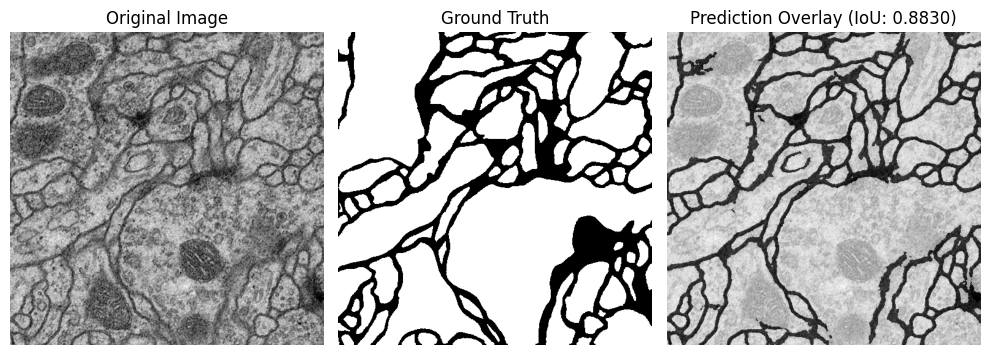

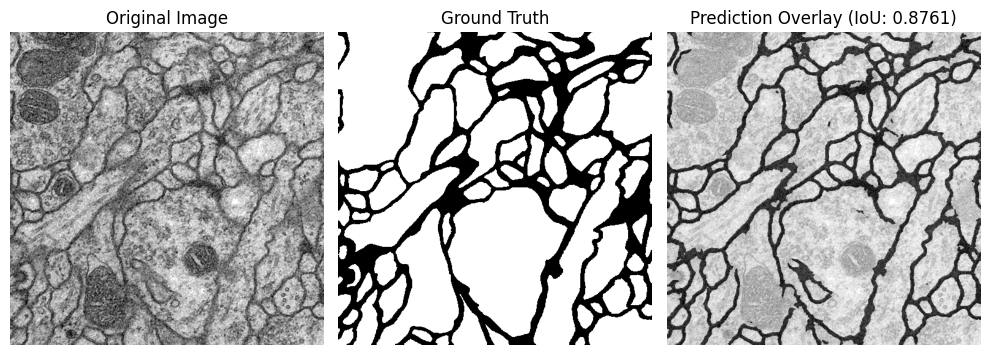

In [159]:
def overlay_predictions(max_images=2, alpha=0.5):
    
    images = min(max_images, len(test_predictions))

    for i in range(images):

        # Get the original image, label, and prediction
        img = test_images[i]
        pred = test_predictions[i]
        label = test_labels[i]

        # Create overlay by blending the prediction mask with the original image
        overlay = img * (1 - alpha) + pred * alpha  # Blended image (grayscale)

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        axes[0].imshow(img, cmap="gray")
        axes[0].set_title("Original Image")

        axes[1].imshow(label, cmap="gray")
        axes[1].set_title("Ground Truth")

        axes[2].imshow(overlay, cmap="gray")
        axes[2].set_title(f"Prediction Overlay (IoU: {test_iou[i]:.4f})")

        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Call function
overlay_predictions()


#### 2. Error Map (Difference Map Visualization)

This metric displays the **absolute difference** between the ground truth and the predicted mask using a heatmap.

Using this metric, we can identify regions where the model performs well and where it makes mistakes.

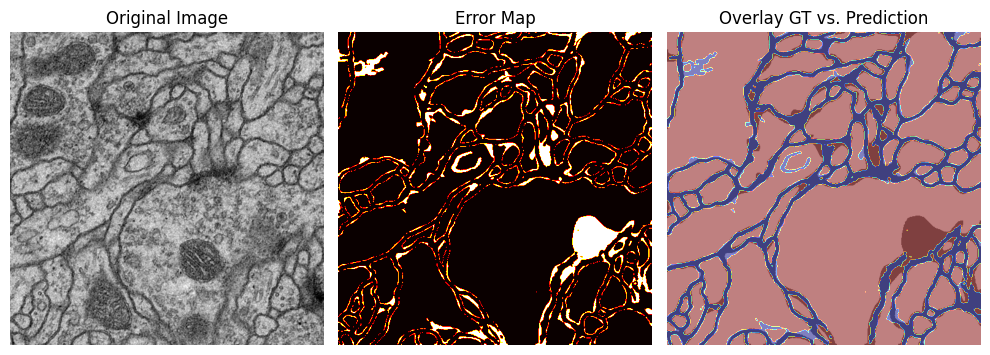

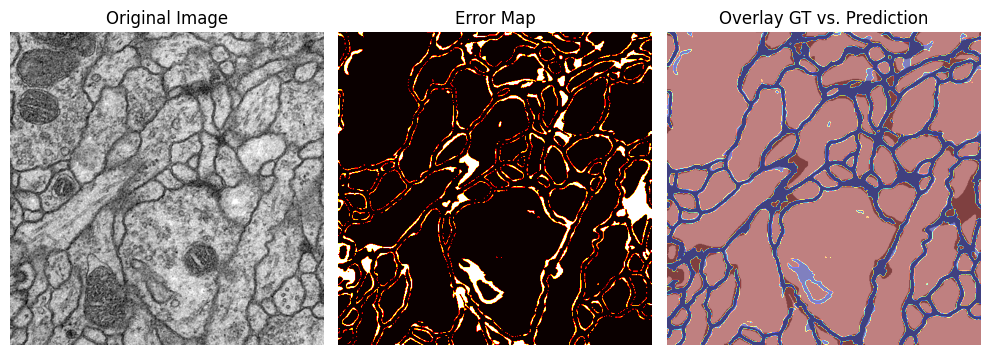

In [160]:
def error_map(max_images=2, alpha=0.5):
    
    images = min(max_images, len(test_predictions))

    for i in range(images):

        # Get the original image, label, and prediction
        img = test_images[i]
        pred = test_predictions[i]
        label = test_labels[i]

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        error = np.abs(label - pred)  # Absolute difference

        axes[0].imshow(img, cmap="gray")
        axes[0].set_title("Original Image")

        axes[1].imshow(error, cmap="hot")
        axes[1].set_title("Error Map")

        axes[2].imshow(label, cmap="gray", alpha=alpha)
        axes[2].imshow(pred, cmap="jet", alpha=alpha)
        axes[2].set_title("Overlay GT vs. Prediction")

        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Call function
error_map()

**Error Map Description:**

Error map highlights the discrepancies between a predicted segmentation and the ground truth (GT).
The black regions indicate correct predictions (low error), while bright colors (e.g., white, yellow, or red) represent high error areas.

**(Overlay GT vs. Prediction) Graph Description:**

This shows the comparison between the ground truth (GT) and the model's prediction
The background is shaded (likely the predicted regions), while the GT contours are overlaid in blue.
Mismatches are visible where the GT and prediction do not align perfectly.

#### 3. Precision-Recall Curve (Graph)

This method computes precision and recall at different thresholds for the output mask.

Using this metric, we evaluates the model's ability to distinguish positive and negative pixels across various confidence levels.

In [161]:
# Generate flat lists of predictions and labels
flat_test_preds = []
flat_test_pred_logits = []
flat_test_labels = []

for array in test_prediction_logits:
    flat_test_pred_logits.extend(array.flatten())

for array in test_predictions:
    flat_test_preds.extend(array.flatten())

for array in test_labels:
    flat_test_labels.extend(array.flatten())

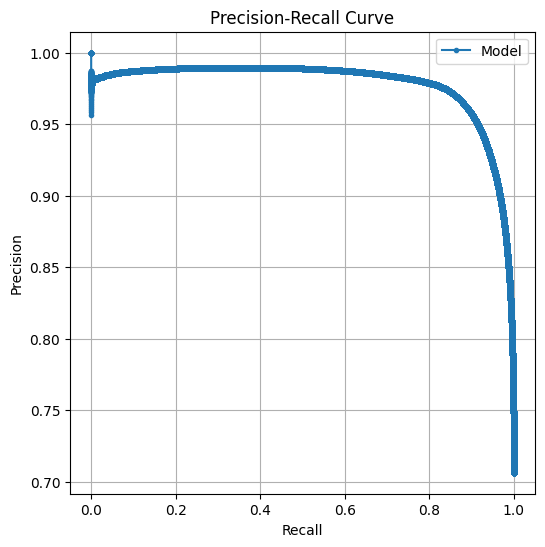

In [162]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot():

    precision, recall, _ = precision_recall_curve(flat_test_labels, flat_test_pred_logits)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, marker=".", label="Model")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Call function
precision_recall_curve_plot()

#### 4. ROC Curve (Graph)

ROC curve allows us to compute true positive rate (TPR) and false positive rate (FPR) at different thresholds.

Using this metric, we measure how well the model separates positive from negative regions.

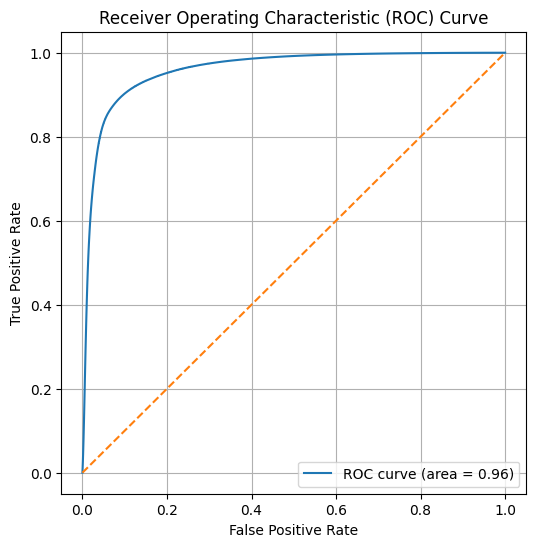

In [163]:
from sklearn.metrics import roc_curve, auc

def roc_curve_plot():
    
    fpr, tpr, _ = roc_curve(flat_test_labels, flat_test_pred_logits)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Call function
roc_curve_plot()

#### 5. IoU Score Distribution Plot (Graph)

This metric displays the intersection over union across all images to measure the consistency of the output with the groundtruth

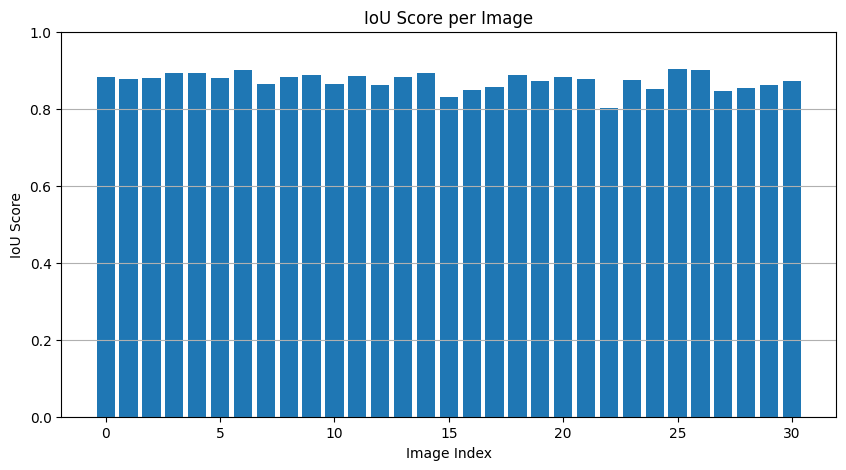

In [164]:
import matplotlib.pyplot as plt

def iou_map():

    # Plot IoU scores
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(test_iou)), test_iou)
    plt.xlabel("Image Index")
    plt.ylabel("IoU Score")
    plt.title("IoU Score per Image")
    plt.ylim(0, 1)
    plt.grid(axis="y")

    plt.show()

# Call function
iou_map()


The IoU scores for all the images are consistent i.e. above **80%** \
This represents the model produces consistent output

#### 6. Model Evaluation Report (Textual)

In [165]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def evaluate_textually():
    
    iou_scores_list = []
    dice_scores_list = []
    precision_list = []
    recall_list = []
    accuracy_list = []

    for i in range(len(test_predictions)):
        
        pred = test_predictions[i]
        label = test_labels[i]

        pred = pred.flatten()
        label = label.flatten()

        # Dice Coefficient
        intersection = (pred * label).sum()
        dice = (2. * intersection + 1e-6) / (pred.sum() + label.sum() + 1e-6)
        dice_scores_list.append(dice)
        # Precision, Recall, Accuracy
        precision = precision_score(label, pred)
        recall = recall_score(label, pred, zero_division=0)
        accuracy = accuracy_score(label, pred)
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)

    # Convert lists to numpy arrays
    iou_scores = np.array(test_iou)
    dice_scores = np.array(dice_scores_list)
    precision_scores = np.array(precision_list)
    recall_scores = np.array(recall_list)
    accuracy_scores = np.array(accuracy_list)

    # Compute Summary Statistics
    avg_loss = sum(test_loss) / len(test_loss)
    mean_iou = np.mean(iou_scores)
    median_iou = np.median(iou_scores)
    std_iou = np.std(iou_scores)

    mean_dice = np.mean(dice_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_accuracy = np.mean(accuracy_scores)

    # Compute Confusion Matrix
    cm = confusion_matrix(flat_test_labels, flat_test_preds)

    # Calculate percentage of True Positives, True Negatives, False Positives, and False Negatives
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    # Generate Text Report
    report = f"""
    ========== Model Evaluation Report ==========
    - Average Loss: {avg_loss:.6f}
    
    - IoU Scores:
      - Mean IoU: {mean_iou:.4f}
      - Median IoU: {median_iou:.4f}
      - Standard Deviation of IoU: {std_iou:.4f}

    - Dice Coefficient: {mean_dice:.4f}

    - Pixel-Wise Classification:
      - Precision: {mean_precision:.4f}
      - Recall: {mean_recall:.4f}
      - Accuracy: {mean_accuracy:.4f}

    - Number of Images Evaluated: {len(iou_scores_list)}

    - Confusion Matrix (Pixel-Level):
        [[TN: {cm[0, 0]}  FP: {cm[0, 1]}]
         [FN: {cm[1, 0]}  TP: {cm[1, 1]}]]

    - Confusion Matrix (Percentage):
        [[TN: {tn/total*100:.4f}  FP: {fp/total*100:.4f}]
         [FN: {fn/total*100:.4f}  TP: {tp/total*100:.4f}]]
    ============================================
    """
    
    print(report)


loss = nn.BCEWithLogitsLoss()
# Call function
evaluate_textually()


    ========== Model Evaluation Report ==========
    - Average Loss: 0.326160
    
    - IoU Scores:
      - Mean IoU: 0.8724
      - Median IoU: 0.8776
      - Standard Deviation of IoU: 0.0216

    - Dice Coefficient: 0.9317

    - Pixel-Wise Classification:
      - Precision: 0.8989
      - Recall: 0.9674
      - Accuracy: 0.9004

    - Number of Images Evaluated: 0

    - Confusion Matrix (Pixel-Level):
        [[TN: 1708985  FP: 601885]
         [FN: 181212  TP: 5372238]]

    - Confusion Matrix (Percentage):
        [[TN: 21.7309  FP: 7.6534]
         [FN: 2.3042  TP: 68.3115]]
    


### Conclusion

* The model gives us 90% accuracy.
* The validation loss is close to training loss across each epoch showing consistent learning
* IoU error is also improved along with the validation loss throughout training
* Precise and recall demonstrate great balance
* ROC shows good curve
* Visual metric such as error heatmap validates our numerical analysis
* Despite having lower number of samples, augmentation has helped achieve great accuracy.
* Confusion matrix also shows higher number of true positive while lower number of false positive and negatives

> Taking aforementioned points into consideration, it can safely be concluded that: \
\
The training procedure was coherent and produced great results.